In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
import time
from torchvision import datasets, transforms
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F

In [33]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root=r'C:\Users\777\PycharmProjects\uchuneyronki\NN\MNIST\CIFAR10', train=True,
                                        download=True, transform=transform)
train_dataloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root=r'C:\Users\777\PycharmProjects\uchuneyronki\NN\MNIST\CIFAR10', train=False,
                                       download=True, transform=transform)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


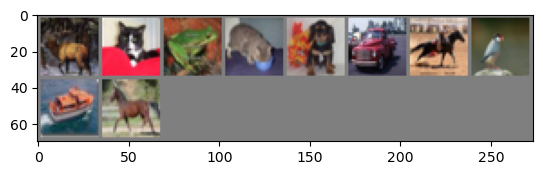

 deer   cat  frog   cat   dog   car horse  bird  ship horse


In [34]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(10)))


In [35]:
total = 0
dic_count = {i: 0 for i in range(10)}
dic_graph = {}

In [36]:
print(len(trainset))
print((len(testset)))

50000
10000


In [6]:
for dat in trainset:
    tens, mark = dat
    dic_count[int(mark)] += 1
    total += 1
tg = 0
for k,v in dic_count.items():
    print(f'Процентоное соотношение класса {classes[tg]} от общего кол-ва цифр: {v*100/total}%')
    dic_graph[classes[tg]]=v
    tg += 1


Процентоное соотношение класса plane от общего кол-ва цифр: 10.0%
Процентоное соотношение класса car от общего кол-ва цифр: 10.0%
Процентоное соотношение класса bird от общего кол-ва цифр: 10.0%
Процентоное соотношение класса cat от общего кол-ва цифр: 10.0%
Процентоное соотношение класса deer от общего кол-ва цифр: 10.0%
Процентоное соотношение класса dog от общего кол-ва цифр: 10.0%
Процентоное соотношение класса frog от общего кол-ва цифр: 10.0%
Процентоное соотношение класса horse от общего кол-ва цифр: 10.0%
Процентоное соотношение класса ship от общего кол-ва цифр: 10.0%
Процентоное соотношение класса truck от общего кол-ва цифр: 10.0%


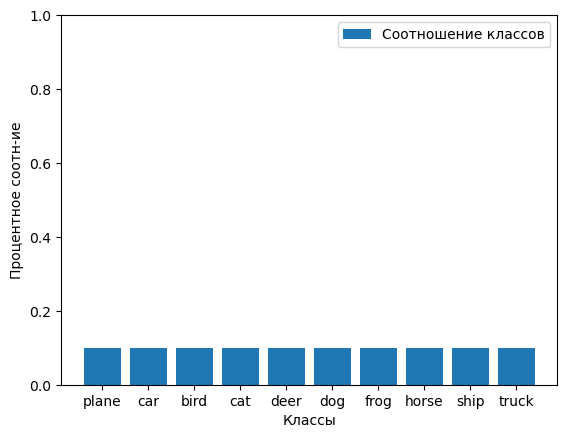

In [7]:
keys = dic_graph.keys()
vals = dic_graph.values()
plt.bar(keys, np.divide(list(vals), sum(vals)), label="Соотношение классов")
plt.ylim(0,1)
plt.ylabel("Процентное соотн-ие")
plt.xlabel("Классы")
plt.xticks(list(keys))
plt.legend()
plt.show()

In [53]:
class CNN_model(nn.Module):
    def __init__(self):
        super(CNN_model, self).__init__()
        self.conv_stack = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 3 * 3, 100),
            nn.ReLU(),
            nn.Linear(100, 10),
        )

    def forward(self, x):
        x = self.conv_stack(x)
        return x

In [54]:
num_epochs = 5
batch_size = 64
learning_rate = 1e-3
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [55]:
model = CNN_model().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [50]:
def train_loop(dataloader, model, loss_function, optimizer):
    num_batches = len(dataloader)

    train_loss = 0

    for imgs, labels in dataloader:
        # предсказание и расчет потерь
        pred = model(imgs.to(device))
        loss = loss_function(pred, labels.to(device))

        # оптимизация
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= num_batches
    print(f"Потери обучения: {train_loss:>8f}")

    return train_loss


def test_loop(dataloader, model, loss_function):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    test_loss, correct = 0, 0

    with torch.no_grad():
        for imgs, labels in dataloader:
            # Compute prediction and loss
            pred = model(imgs.to(device))
            loss = loss_function(pred, labels.to(device))

            test_loss += loss.item()
            correct += (
                (pred.argmax(1) == labels.to(device)).type(torch.float).sum().item()
            )

    test_loss /= num_batches
    correct /= size
    print(f"Потери на тестовых данных: {test_loss:>8f}, Точность модели на тестовых данных: {(100*correct):>0.1f}% \n")

    return test_loss

In [56]:
loss_history = {"train": [], "test": []}
start_time = time.time()
for i in range(num_epochs):
    print(f"Эпоха номер {i+1}")
    train_loss = train_loop(train_dataloader, model, loss_function, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_function)

    loss_history["train"].append(train_loss)
    loss_history["test"].append(test_loss)
print(f"Обучение завершнео за {num_epochs} эпох, затраченное время: {round(time.time() - start_time, 3)} секунд")

Эпоха номер 1


RuntimeError: mat1 and mat2 shapes cannot be multiplied (64x2048 and 288x100)